# This notebook shows an example where a set of electrodes are selected from a dataset and then LFP is extracted from those electrodes and then written to a new NWB file


## The following steps must be completed before running this notebook:
### 1) Set up access to a DataJoint database. See https://tutorials.datajoint.io/
### 2) Install pynwb. 
    See https://pynwb.readthedocs.io/en/stable/getting_started.html#installation
    Note: currently this requires pynwb 1.3.3 or above and hdmf 2.0.1 or above, so use the latest development versions, not the conda versions
### 3) Install the ndx-fl-novela package. 
     conda install -c novelakrk ndx-fl-novela
### 4) Download the example franklab NWB file from DropBox. 
    https://www.dropbox.com/to_be_updated

#### Make sure we're in the franklabnwb/franklabnwb directory. 
#### Eventually this will be unnecessary because the package will properly installed

#### Load all of the relevant modules and set the environment variables. 
Note that the datadir and datadir/analysis must exist

In [1]:
%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
%load_ext autoreload
%autoreload 2


import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj

# the commands below can be run once to update your global configuration

dj.config["enable_python_native_blobs"] = True
dj.config["database.user"] = 'root'
dj.config["databasse.password"] = 'tutorial'
dj.config.save_global()

import nwb_datajoint as nd
import ndx_franklab_novela.probe

data_dir = '/Users/loren/data/nwb_builder_test_data'
os.environ['NWB_DATAJOINT_BASE_DIR'] = data_dir
os.environ['KACHERY_STORAGE_DIR'] = os.path.join(data_dir, 'kachery-storage')



env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@localhost:3306


18:29:35 [I] klustakwik KlustaKwik2 version 0.2.6


#### Next we select the NWB file, which corresponds to the dataset we want to extract LFP from

In [2]:
nwb_file_names = nd.common.Nwbfile().fetch('nwb_file_name')
# take the first one for this demonstration
nwb_file_name = nwb_file_names[0]
print(nwb_file_name)

beans20190718.nwb


#### Create the standard LFP Filters. This only needs to be done once.

In [3]:
nd.common.FirFilter().create_standard_filters()

### Select every fourth electrode for LFP

In [4]:
electrode_ids = nd.common.Electrode.fetch('electrode_id')
lfp_electrode_ids = electrode_ids[range(0, len(electrode_ids), 4)]
nd.common.LFPSelection().set_lfp_electrodes(nwb_file_name, lfp_electrode_ids.tolist())


About to delete:
`common_ephys`.`l_f_p_band_selection__l_f_p_band_electrode`: 3 items
`common_ephys`.`l_f_p_band_selection`: 1 items
`common_ephys`.`_l_f_p`: 1 items
`common_ephys`.`l_f_p_selection__l_f_p_electrode`: 64 items
`common_ephys`.`l_f_p_selection`: 1 items


Proceed? [yes, No]:  no


Cancelled deletes.


### Or select one electrode for LFP


In [3]:
nd.common.LFPSelection().set_lfp_electrodes(nwb_file_name, [2])

About to delete:
`common_ephys`.`l_f_p_selection__l_f_p_electrode`: 128 items
`common_ephys`.`l_f_p_selection`: 1 items


Proceed? [yes, No]:  yes


Committed.


### Populate the LFP table. Note that this takes 2 hours or so on a laptop if you use all electrodes

In [4]:
import time
tic = time.perf_counter()
nd.common.LFP().populate()
toc = time.perf_counter()
toc - tic

writing new NWB file beans20190718_00000001.nwb
Output array should have shape (1091950, 64) and dtype <f8
Output array should have shape (212812, 64) and dtype <f8
Output array should have shape (2557744, 64) and dtype <f8
Output array should have shape (1356939, 64) and dtype <f8
Output array should have shape (1680945, 64) and dtype <f8
Checking output array shape is disabled, make sure portion of output array has shape (1091950, 64)
Checking output array shape is disabled, make sure portion of output array has shape (212812, 64)
Checking output array shape is disabled, make sure portion of output array has shape (2557744, 64)
Checking output array shape is disabled, make sure portion of output array has shape (1356939, 64)
Checking output array shape is disabled, make sure portion of output array has shape (1680945, 64)


8340.460124849

### Now that we've created the LFP object we can perform a second level of filtering for a band of interest, in this case the theta band
We first need to create the filter

In [9]:
lfp_sampling_rate = (nd.common.LFP() & {'nwb_file_name' : nwb_file_name}).fetch1('lfp_sampling_rate')
filter_name = 'Theta 5-11 Hz'
nd.common.FirFilter().add_filter(filter_name, lfp_sampling_rate, 'bandpass', [4, 5, 11, 12], 'theta filter for 1 Khz data')

Next we add an entry for the LFP Band and the electrodes we want to filter

In [10]:
# assume that we've filtered all the electrodes; change this if not
lfp_band_electrode_ids = [0, 4, 8]

# set the interval list name corresponding to the second epoch (a run session)
interval_list_name = '02_r1'

# set the reference to -1 to indicate no reference for all channels
ref_elect = [-1]

# desired sampling rate
lfp_band_sampling_rate = lfp_sampling_rate // 10

In [91]:
nd.common.LFPBandSelection().set_lfp_band_electrodes(nwb_file_name, lfp_band_electrode_ids, filter_name, interval_list_name, ref_elect, lfp_band_sampling_rate)

Check to make sure it worked

In [92]:
nd.common.LFPBandSelection().LFPBandElectrode()

nwb_file_name the name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,reference_elect_id the reference electrode to use; -1 for no reference
beans20190718.nwb,Theta 5-11 Hz,1000,0,0,-1
beans20190718.nwb,Theta 5-11 Hz,1000,0,4,-1
beans20190718.nwb,Theta 5-11 Hz,1000,0,8,-1


In [93]:
(nd.common.LFP() & {'nwb_file_name' : nwb_file_name}).fetch_nwb(limit=1)[0]['lfp']

filtered data pynwb.ecephys.ElectricalSeries at 0x140228951750352
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (6900390, 64), type "<i2">
  description: no description
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  interval: 1
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (6900390,), type "<f8">
  timestamps_unit: seconds
  unit: volts

In [5]:
nd.common.LFPBand().populate()

Theta 5-11 Hz 100
writing new NWB file beans20190718_00000006.nwb
Output array should have shape (277056, 3) and dtype <f8
[0, 4, 8] [0 4 8]
Checking output array shape is disabled, make sure portion of output array has shape (277056, 3)


In [97]:
nd.common.LFPBand().delete()

[autoreload of nwb_datajoint.common.common_ephys failed: Traceback (most recent call last):
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packag

About to delete:
`common_ephys`.`__l_f_p_band`: 1 items


Proceed? [yes, No]:  yes


Committed.


### Now we can plot the original signal, the LFP filtered trace, and the theta filtered trace together.
Much of the code below could be replaced by a function calls that would return the data from each electrical series

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
#get the three electrical series objects and the indeces of the electrodes we band pass filtered
orig_eseries = (nd.common.Raw() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['nwb']
orig_elect_indeces = nd.common.get_electrode_indeces(orig_eseries, lfp_band_electrode_ids)

lfp_eseries = (nd.common.LFP() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['lfp']
lfp_elect_indeces = nd.common.get_electrode_indeces(lfp_eseries, lfp_band_electrode_ids)

lfp_band_eseries = (nd.common.LFPBand() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['filtered_data']
lfp_band_elect_indeces = nd.common.get_electrode_indeces(lfp_band_eseries, lfp_band_electrode_ids)


In [23]:
# get a list of times for the first run epoch and then select a 2 second interval 100 seconds from the beginning
run1times = (nd.common.IntervalList & {'interval_list_name' : '02_r1'}).fetch1('valid_times')
plottimes = [run1times[0][0] + 101, run1times[0][0] + 102]

In [24]:
# get the time indeces for each dataset
orig_time_ind = np.argwhere(np.logical_and(orig_eseries.timestamps > plottimes[0], orig_eseries.timestamps < plottimes[1]))
lfp_time_ind = np.argwhere(np.logical_and(lfp_eseries.timestamps > plottimes[0], lfp_eseries.timestamps < plottimes[1]))
lfp_band_time_ind = np.argwhere(np.logical_and(lfp_band_eseries.timestamps > plottimes[0], lfp_band_eseries.timestamps < plottimes[1]))

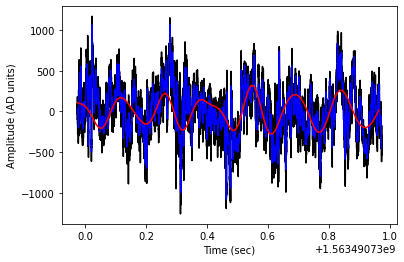

In [25]:
plt.plot(orig_eseries.timestamps[orig_time_ind], orig_eseries.data[orig_time_ind,orig_elect_indeces[1]], 'k-')
plt.plot(lfp_eseries.timestamps[lfp_time_ind], lfp_eseries.data[lfp_time_ind,lfp_elect_indeces[1]], 'b-')
plt.plot(lfp_band_eseries.timestamps[lfp_band_time_ind], lfp_band_eseries.data[lfp_band_time_ind,lfp_band_elect_indeces[1]], 'r-')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (AD units)')

plt.show()